In [1]:
import sys
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import toml
import time
from ipywidgets import *
import cv2
import uuid
from absl import logging
logging.set_verbosity(0)

import copy
import os
import json

from datetime import datetime

In [47]:
from lc_utils import load_imu_data
from submap import Submap
from lc_utils import combine_yelli_poses, get_inverse_yelli_pose, imu_pose_estimate, normalize_pose

In [3]:
from ati.perception.lidar import lidar_pb, lidar_utils
from ati.perception.lidar.lidar_voxel import voxel_filter
from ati.perception.utils.voxel_filter_utils import voxel_filter_fast
from ati.perception.lidar.lidar_frame import *
from ati.slam.yelli import utils, grid
from utils.imu_tracker import ImuTracker

data [0.4 0.4 0.9 0.  0.9 0.4 0.9 0.2 1.  0.2 1.  0.7 0.5 0.1 0.7]
unique [0.  0.1 0.2 0.4 0.5 0.7 0.9 1. ]
sorted [0.  0.1 0.2 0.2 0.4 0.4 0.4 0.5 0.7 0.7 0.9 0.9 0.9 1.  1. ]
indices of unique values [ 0  1  2  4  7  8 10 13]
argsort [ 3 13  7  9  0  1  5 12 11 14  2  4  6  8 10]


In [4]:
max_frames = 32000 
data_dir = "/atidata/demo/comstar/2021-09-21-08-53-57-mini20-03-manual_comstar_mapping_run/"
bootstrap_frames =20

grid_res = 0.02
grid_alpha =1
num_submap_range_data = 90
alpha= 1.05
start_frame = 50

grid_params = {
    "x": (-0.1, 0.1),
#    "x": (-0.2, 0.2),
#    "x": (-0.4, 0.4),
#    "y": (-0.02, 0.30),
    "y": (-0.20, 0.30),
#    "y": (-0.40, 0.60),
    "theta": (-0.2, 0.2),
#    "num_x": 11,
#    "num_x": 22,
#    "num_x": 44,
#    "num_y": 17,
#    "num_y" : 26,
#    "num_y" : 52,
#    "num_t": 41,
    "num_t": 100,
    
}

grid_params['num_x'] = int((grid_params['x'][1] - grid_params['x'][0])/grid_res + 1)
grid_params['num_y'] = int((grid_params['y'][1] - grid_params['y'][0])/grid_res + 1)



zmin, zmax = 0.3, 2.5

In [5]:
z_slices = [(zmin,zmax)]
print("Using Z slices:", z_slices)

Using Z slices: [(0.3, 2.5)]


In [6]:
imu_data = load_imu_data(data_dir)
imu_tracker = ImuTracker()
imu_bias_initialized = False
i = 0
while not imu_bias_initialized:
    imu_bias_initialized = imu_tracker.get_initial_gyro_bias(imu_data.iloc[i])
    i += 1


In [7]:
pose = np.array([0.,0., np.pi/2])
prev_pose = pose.copy()
spose = pose #local submap pose

In [8]:
submaps, active_submaps, finished_submaps = [], [], [] #active_submaps contain two two at a time -- implementation for overlapping submaps
best_scores = []
node_poses = [] #? poses of inserted frames in the global frame
inserted_frame_ids=[] #frame_id for inserted frame
submap = Submap(spose.copy(), grid_res, grid_alpha)
active_submaps.append(submap)

In [9]:
frame_id=0
try:
    lpb = lidar_pb.LidarSmallPb(data_dir)
except:
    lpb = lidar_pb.LidarPb(data_dir)
prev_frame_time, prev_frame = lpb.get_frame(start_frame - 2)
num_frames = np.minimum(len(lpb.list_frames()), max_frames)
print(f"total frames {num_frames}")
for frame_id in range(start_frame, num_frames - 1):
    #if frame_id % 2 != 0:
        #continue
    try:
        frame_time, frame = lpb.get_frame(frame_id)
    except:
        print(f"skipping {frame_id}. divide-by-zero error")
        continue

    frame = np.copy(frame[:, :6]).astype(np.float64)
    frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
    frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
    filtered_frame,_ = voxel_filter_fast(voxel_filter(frame, voxel_size=0.05), trunc=False, voxel = 0.5)
    frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
    
    if frame_id < start_frame + bootstrap_frames:
        print("Num Bootstrap insertions", active_submaps[0].num_insertions)
        spose = combine_yelli_poses(pose, get_inverse_yelli_pose(active_submaps[0].pose)) # pose wrt submap origin
        node_poses.append(pose)
        inserted_frame_ids.append(frame_id)
        active_submaps[0].insert_points(frame_z, spose, frame_id, node_id = len(node_poses)-1 )
#         frame_list.append(frame_id)
#         poses.append(pose)
        prev_insert_ts = frame_time
        prev_frame_time, prev_frame = frame_time, frame
        last_inserted_pose = pose.copy()
        continue
    
    relevant_imu_data = imu_data[imu_data["time"].between(prev_frame_time, frame_time)]
    for imu_idx in range(relevant_imu_data.shape[0]):
        imu_tracker.add_imu_data(relevant_imu_data.iloc[imu_idx])
    
    pose_estimate = imu_pose_estimate(imu_tracker, frame_time, pose) #only theta around which we need to search changes
    spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[0].pose),pose_estimate)
    search_space = utils.grid_space(center=spose_estimate, **grid_params)
    scores = active_submaps[0].search(filtered_frame, search_space, count_once = False)
    best = np.argmax(scores)
    best_scores.append(scores[best])
    
    spose = search_space[best]
    pose = combine_yelli_poses(active_submaps[0].pose, spose)
    if (np.linalg.norm(pose[:2]-last_inserted_pose[:2])> 0.1 or (prev_insert_ts - frame_time)>1) :

        node_poses.append(pose)
        inserted_frame_ids.append(frame_id)
        active_submaps[0].insert_points(frame_z, spose, frame_id, node_id=len(node_poses)-1)
        if len(active_submaps) ==1:
        
            if active_submaps[0].num_insertions >= int(num_submap_range_data/2):
                active_submaps.append(Submap(pose.copy(), grid_res, grid_alpha))
                s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose),pose)
                active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
                #print(f"spose {spose}, s2pose {s2pose}")
                
        else:
            
            s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose),pose)
            active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
            #print(f"len else spose {spose}, s2pose {s2pose}")
            
        if active_submaps[0].num_insertions >= num_submap_range_data - 1:
            active_submaps[0].finished = True
            finished_submaps.append(active_submaps.pop(0))
            active_submaps.append(Submap(pose.copy(), grid_res, grid_alpha))
            s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose), pose)
            active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
        
        #print("num active submaps", len(active_submaps))
        prev_insert_ts = frame_time
        last_inserted_pose = pose.copy()
    if frame_id % 250 == 0:
        print(f"frame:{frame_id} scores:{best_scores[-1]} best pose:{pose}  ")
    prev_frame_time, prev_frame = frame_time, frame
node_poses = np.array(node_poses)
inserted_frame_ids = np.array(inserted_frame_ids)
# print(f"final pose {poses[-1]}")
    

total frames 9739
Num Bootstrap insertions 0
Num Bootstrap insertions 1
Num Bootstrap insertions 2
Num Bootstrap insertions 3
Num Bootstrap insertions 4
Num Bootstrap insertions 5
Num Bootstrap insertions 6
Num Bootstrap insertions 7
Num Bootstrap insertions 8
Num Bootstrap insertions 9
Num Bootstrap insertions 10
Num Bootstrap insertions 11
Num Bootstrap insertions 12
Num Bootstrap insertions 13
Num Bootstrap insertions 14
Num Bootstrap insertions 15
Num Bootstrap insertions 16
Num Bootstrap insertions 17
Num Bootstrap insertions 18
Num Bootstrap insertions 19
frame:250 scores:3800.0 best pose:[-0.02036254 -0.022416    1.57181616]  
frame:500 scores:3115.0 best pose:[-0.00174796 -0.00564116  1.57293598]  
frame:750 scores:4244.0 best pose:[-0.02502153 -0.00720476  1.56983312]  
frame:1000 scores:2897.0 best pose:[-0.00919456 -0.03009485  1.57013424]  
frame:1250 scores:2970.0 best pose:[-0.01265837 -0.01240524  1.56940769]  
frame:1500 scores:3974.0 best pose:[-0.01739987 -0.01277982 

NameError: name 'poses' is not defined

(-10.184242434773722,
 61.56379820710717,
 -4.3695713393604585,
 79.02243831664961)

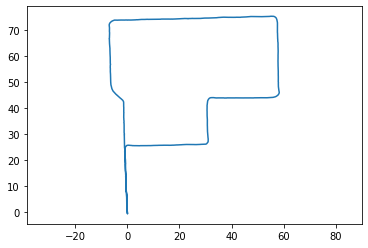

In [11]:
node_poses = np.array(node_poses)
st = 0; stp = -1
plt.figure()
plt.plot(node_poses[st:stp,0], node_poses[st:stp,1], )
plt.axis('equal')


<IPython.core.display.Javascript object>


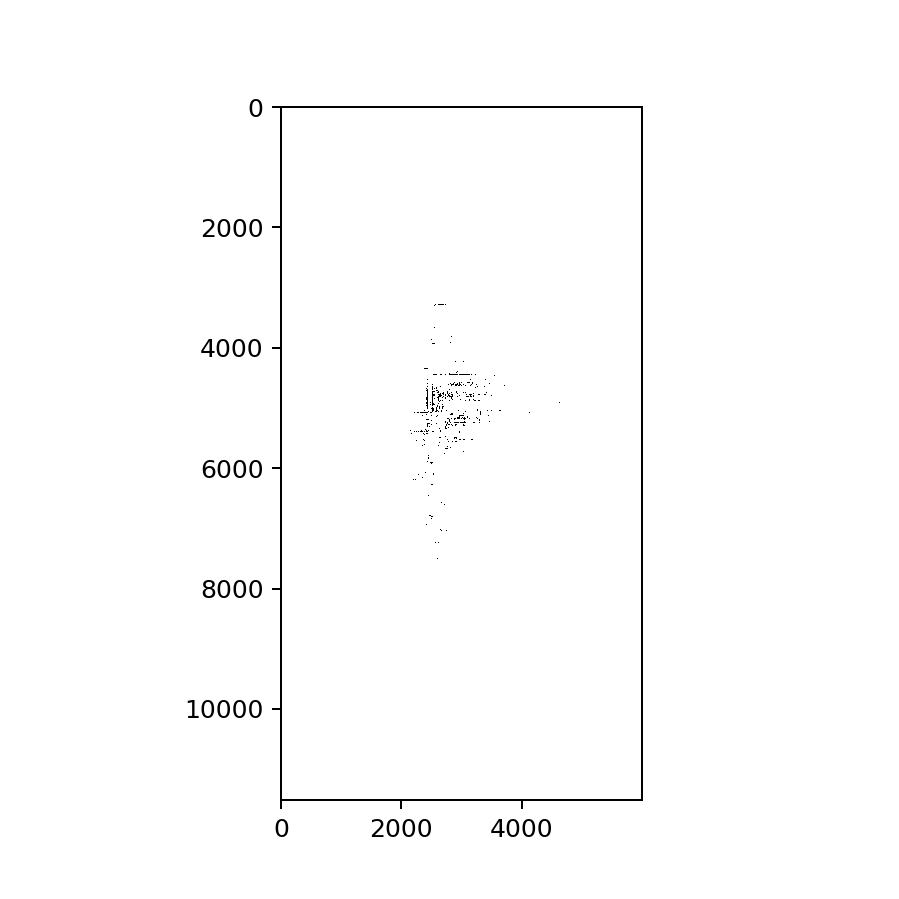

In [19]:
#%matplotlib inline
%matplotlib notebook
%matplotlib notebook
plt.figure(figsize = (5,5))
#plt.imshow(1-(finished_submaps[2].grid.grid.T> 0), cmap='gray') 
plt.imshow(1 - (finished_submaps[0].grid.grid.T>0), cmap='gray') 
#print(np.sum(finished_submaps[1].grid.grid >0))

In [21]:
print( len(finished_submaps), len(node_poses), len(inserted_frame_ids))

45 2050 2050


In [63]:
import branch_bound as bb
from importlib import reload
from constraint import Constraint
import pg

reload(pg)

<module 'pg' from '/home/anujraaj/helpers/anujraaj/loop_closure/pg.py'>

In [43]:
x_search_window = (-10,10)
y_search_window = (-10,10)
angle_search_window = (-np.pi/6, np.pi/6)

node_dists = np.cumsum(np.linalg.norm(node_poses[1:,:2]-node_poses[:-1,:2], axis = 1))
node_dists = np.concatenate(([0],node_dists))
print(len(node_dists), len(node_poses))

2050 2050


In [44]:
constraints=[]
for sid in range(len(finished_submaps)):
#for sid in range(2):
    submap = finished_submaps[sid]
    hgrids =  bb.compute_hierarchical_grid(submap.grid, num_levels=4)
    for nid in range(len(node_poses)):
        npose = node_poses[nid]
        dist = np.linalg.norm(npose[:2] - submap.pose[:2])
        node_dist = abs(node_dists[nid] - node_dists[submap.node_ids[0]])
        if node_dist < 20:
            continue
        if nid not in submap.node_ids and (dist < 10):
            fr_id = inserted_frame_ids[nid]
            ts, frame = lpb.get_frame(fr_id)
            frame = np.copy(frame[:, :6]).astype(np.float64)
            frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
            frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
            frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
            if len(frame_z) < 500:
                continue
            #Check all quadrants have points
            if (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] < 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] < 0)) <10):
                continue
            frame_z,_ = voxel_filter_fast(frame_z, trunc=False, voxel = 0.25)  
            
            spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(submap.pose), npose)
            hpose = bb.hierarchical_search(hgrids, spose_estimate, frame_z,
                                        x_search_window,y_search_window,angle_search_window
                                        , max_range = 60, score_th = 10)
            print("sid, nids, pose",[submap.node_ids[0], nid], hpose)
            if hpose is not None:                
                constraints.append(Constraint([submap.node_ids[0], nid], hpose))

/home/anujraaj/mule/.venv/lib/python3.7/site-packages/numba/core/typed_passes.py:332: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "branch_bound.py", line 29:
@numba.njit(fastmath=True, parallel=True)                    
def compute_half_res_grid(half_res_grid, full_res_grid):
^

  state.func_ir.loc))


Score below thresold 10 score :8.925540432345876
sid, nids, pose [0, 1982] None
Score below thresold 10 score :8.215821152192605
sid, nids, pose [0, 1983] None
sid, nids, pose [0, 1984] [-0.577396    9.86210153 -1.60244241]
sid, nids, pose [0, 1986] [-0.5894169   9.31092498 -1.59026081]
sid, nids, pose [0, 1987] [-0.56980379  9.22459848 -1.59565891]
sid, nids, pose [0, 1988] [-0.62497104  9.14169194 -1.5920539 ]
Score below thresold 10 score :8.734726688102894
sid, nids, pose [0, 1989] None
Score below thresold 10 score :9.547638773819386
sid, nids, pose [0, 1990] None
sid, nids, pose [0, 1991] [-0.62308619  8.72225941 -1.46029132]
Score below thresold 10 score :9.403335860500379
sid, nids, pose [0, 1994] None
sid, nids, pose [0, 1995] [-0.5276678   8.13218585 -1.52808473]
Score below thresold 10 score :9.572741194486984
sid, nids, pose [0, 1996] None
Score below thresold 10 score :9.565629228687415
sid, nids, pose [0, 1997] None
Score below thresold 10 score :8.27470217238963
sid, nid

Score below thresold 10 score :8.833217993079584
sid, nids, pose [44, 2025] None
Score below thresold 10 score :9.66855702583491
sid, nids, pose [44, 2027] None
sid, nids, pose [44, 2028] [-0.34351566 -0.34142611 -1.495972  ]
Score below thresold 10 score :8.855530474040632
sid, nids, pose [44, 2029] None
Score below thresold 10 score :9.353278166772757
sid, nids, pose [44, 2030] None
Score below thresold 10 score :9.295819935691318
sid, nids, pose [44, 2031] None
Score below thresold 10 score :9.548528490920475
sid, nids, pose [44, 2032] None
Score below thresold 10 score :9.705357142857142
sid, nids, pose [44, 2033] None
Score below thresold 10 score :9.76961394769614
sid, nids, pose [44, 2035] None
Score below thresold 10 score :9.362903225806452
sid, nids, pose [44, 2036] None
Score below thresold 10 score :8.870991253644315
sid, nids, pose [44, 2038] None
Score below thresold 10 score :9.125316455696202
sid, nids, pose [44, 2039] None
Score below thresold 10 score :9.0943989930774

Score below thresold 10 score :9.70431654676259
sid, nids, pose [88, 2024] None
Score below thresold 10 score :9.997231833910035
sid, nids, pose [88, 2025] None
Score below thresold 10 score :9.172022684310019
sid, nids, pose [88, 2027] None
Score below thresold 10 score :9.453900709219859
sid, nids, pose [88, 2028] None
Score below thresold 10 score :8.419864559819413
sid, nids, pose [88, 2029] None
Score below thresold 10 score :9.901973265436029
sid, nids, pose [88, 2030] None
Score below thresold 10 score :9.781993569131833
sid, nids, pose [88, 2031] None
Score below thresold 10 score :9.939887288666249
sid, nids, pose [88, 2032] None
Score below thresold 10 score :9.214923469387756
sid, nids, pose [88, 2033] None
Score below thresold 10 score :8.716687422166874
sid, nids, pose [88, 2035] None
Score below thresold 10 score :9.04233870967742
sid, nids, pose [88, 2036] None
Score below thresold 10 score :7.831632653061225
sid, nids, pose [88, 2038] None
Score below thresold 10 score 

Score below thresold 10 score :8.11621021465581
sid, nids, pose [132, 1984] None
Score below thresold 10 score :7.75
sid, nids, pose [132, 1986] None
Score below thresold 10 score :9.459649122807017
sid, nids, pose [132, 1987] None
Score below thresold 10 score :8.497420781134856
sid, nids, pose [132, 1988] None
Score below thresold 10 score :8.215434083601286
sid, nids, pose [132, 1989] None
Score below thresold 10 score :7.31897265948633
sid, nids, pose [132, 1990] None
Score below thresold 10 score :7.043740573152338
sid, nids, pose [132, 1991] None
Score below thresold 10 score :7.35557240333586
sid, nids, pose [132, 1994] None
Score below thresold 10 score :7.121212121212121
sid, nids, pose [132, 1995] None
Score below thresold 10 score :7.031393568147013
sid, nids, pose [132, 1996] None
Score below thresold 10 score :7.307171853856563
sid, nids, pose [132, 1997] None
Score below thresold 10 score :7.479327259985984
sid, nids, pose [132, 1998] None
Score below thresold 10 score :6

Score below thresold 10 score :8.330104321907601
sid, nids, pose [176, 1927] None
Score below thresold 10 score :8.0890625
sid, nids, pose [176, 1928] None
Score below thresold 10 score :7.577543859649123
sid, nids, pose [176, 1929] None
Score below thresold 10 score :7.3075098814229245
sid, nids, pose [176, 1932] None
Score below thresold 10 score :6.678939617083947
sid, nids, pose [176, 1933] None
Score below thresold 10 score :6.963890935887989
sid, nids, pose [176, 1934] None
Score below thresold 10 score :6.828322784810126
sid, nids, pose [176, 1935] None
Score below thresold 10 score :8.444524495677234
sid, nids, pose [176, 1937] None
Score below thresold 10 score :7.909222948438635
sid, nids, pose [176, 1938] None
Score below thresold 10 score :8.738924050632912
sid, nids, pose [176, 1939] None
Score below thresold 10 score :7.0633928571428575
sid, nids, pose [176, 1940] None
Score below thresold 10 score :7.911692559280458
sid, nids, pose [176, 1941] None
Score below thresold 1

Score below thresold 10 score :7.2953105196451205
sid, nids, pose [220, 1880] None
Score below thresold 10 score :8.685276073619631
sid, nids, pose [220, 1881] None
Score below thresold 10 score :8.822192513368984
sid, nids, pose [220, 1882] None
Score below thresold 10 score :8.12875816993464
sid, nids, pose [220, 1884] None
Score below thresold 10 score :6.946666666666666
sid, nids, pose [220, 1885] None
Score below thresold 10 score :6.58213058419244
sid, nids, pose [220, 1886] None
Score below thresold 10 score :6.727146814404432
sid, nids, pose [220, 1887] None
Score below thresold 10 score :6.947229551451187
sid, nids, pose [220, 1888] None
Score below thresold 10 score :7.157348242811501
sid, nids, pose [220, 1890] None
Score below thresold 10 score :7.243647234678625
sid, nids, pose [220, 1891] None
Score below thresold 10 score :7.8348178137651825
sid, nids, pose [220, 1892] None
Score below thresold 10 score :7.077242524916944
sid, nids, pose [220, 1893] None
Score below thre

Score below thresold 10 score :5.677379480840544
sid, nids, pose [264, 1878] None
Score below thresold 10 score :5.529919802590993
sid, nids, pose [264, 1879] None
Score below thresold 10 score :4.08871989860583
sid, nids, pose [264, 1880] None
Score below thresold 10 score :4.995092024539877
sid, nids, pose [264, 1881] None
Score below thresold 10 score :5.032754010695188
sid, nids, pose [264, 1882] None
Score below thresold 10 score :3.9457516339869283
sid, nids, pose [264, 1884] None
Score below thresold 10 score :4.047407407407407
sid, nids, pose [264, 1885] None
Score below thresold 10 score :3.8962199312714776
sid, nids, pose [264, 1886] None
Score below thresold 10 score :3.761080332409972
sid, nids, pose [264, 1887] None
Score below thresold 10 score :4.073218997361478
sid, nids, pose [264, 1888] None
Score below thresold 10 score :4.603035143769968
sid, nids, pose [264, 1890] None
Score below thresold 10 score :4.455156950672646
sid, nids, pose [264, 1891] None
Score below thr

Score below thresold 10 score :6.914271555996035
sid, nids, pose [1848, 229] None
Score below thresold 10 score :6.613297872340426
sid, nids, pose [1848, 230] None
Score below thresold 10 score :7.16421052631579
sid, nids, pose [1848, 231] None
Score below thresold 10 score :7.1938028169014085
sid, nids, pose [1848, 232] None
Score below thresold 10 score :7.515469935785172
sid, nids, pose [1848, 233] None
Score below thresold 10 score :7.484883720930233
sid, nids, pose [1848, 234] None
Score below thresold 10 score :7.299448867115738
sid, nids, pose [1848, 235] None
Score below thresold 10 score :7.045949214026602
sid, nids, pose [1848, 236] None
Score below thresold 10 score :7.1537492123503466
sid, nids, pose [1848, 237] None
Score below thresold 10 score :6.568676196395277
sid, nids, pose [1848, 238] None
Score below thresold 10 score :6.345132743362832
sid, nids, pose [1848, 239] None
Score below thresold 10 score :6.374756018217306
sid, nids, pose [1848, 240] None
Score below thr

Score below thresold 10 score :8.07391826923077
sid, nids, pose [1892, 159] None
Score below thresold 10 score :7.44017094017094
sid, nids, pose [1892, 160] None
Score below thresold 10 score :7.822890025575448
sid, nids, pose [1892, 161] None
Score below thresold 10 score :8.083228247162673
sid, nids, pose [1892, 162] None
Score below thresold 10 score :9.588848039215685
sid, nids, pose [1892, 163] None
Score below thresold 10 score :9.231394621638524
sid, nids, pose [1892, 164] None
Score below thresold 10 score :9.223140495867769
sid, nids, pose [1892, 165] None
Score below thresold 10 score :9.331391585760517
sid, nids, pose [1892, 166] None
Score below thresold 10 score :9.1828025477707
sid, nids, pose [1892, 167] None
Score below thresold 10 score :9.540834845735027
sid, nids, pose [1892, 168] None
Score below thresold 10 score :8.343421865348981
sid, nids, pose [1892, 169] None
Score below thresold 10 score :9.782227784730914
sid, nids, pose [1892, 170] None
Score below thresold

Score below thresold 10 score :3.2090352220520675
sid, nids, pose [1892, 260] None
Score below thresold 10 score :3.2540453074433655
sid, nids, pose [1892, 261] None
Score below thresold 10 score :3.1510457010069715
sid, nids, pose [1892, 262] None
Score below thresold 10 score :3.145564821834723
sid, nids, pose [1892, 263] None
Score below thresold 10 score :3.2808823529411764
sid, nids, pose [1892, 264] None
Score below thresold 10 score :3.277297721916732
sid, nids, pose [1892, 265] None
Score below thresold 10 score :3.318590704647676
sid, nids, pose [1892, 266] None
Score below thresold 10 score :3.694686756542427
sid, nids, pose [1892, 267] None
Score below thresold 10 score :3.7830687830687832
sid, nids, pose [1892, 268] None
Score below thresold 10 score :3.5686994856722998
sid, nids, pose [1892, 269] None
Score below thresold 10 score :3.5565149136577707
sid, nids, pose [1892, 270] None
Score below thresold 10 score :3.5468053491827636
sid, nids, pose [1892, 271] None
Score be

Score below thresold 10 score :8.906642728904847
sid, nids, pose [1936, 133] None
Score below thresold 10 score :9.36
sid, nids, pose [1936, 134] None
Score below thresold 10 score :8.959534368070953
sid, nids, pose [1936, 135] None
Score below thresold 10 score :9.854523950325252
sid, nids, pose [1936, 136] None
Score below thresold 10 score :9.461226851851851
sid, nids, pose [1936, 137] None
Score below thresold 10 score :9.72225416906268
sid, nids, pose [1936, 138] None
Score below thresold 10 score :8.758169934640524
sid, nids, pose [1936, 139] None
Score below thresold 10 score :9.276887871853546
sid, nids, pose [1936, 140] None
Score below thresold 10 score :7.628796400449944
sid, nids, pose [1936, 141] None
Score below thresold 10 score :7.045002922267679
sid, nids, pose [1936, 142] None
Score below thresold 10 score :8.806285714285714
sid, nids, pose [1936, 143] None
Score below thresold 10 score :8.348341232227488
sid, nids, pose [1936, 144] None
Score below thresold 10 score 

Score below thresold 10 score :2.863953488372093
sid, nids, pose [1936, 234] None
Score below thresold 10 score :2.818126148193509
sid, nids, pose [1936, 235] None
Score below thresold 10 score :2.6330108827085854
sid, nids, pose [1936, 236] None
Score below thresold 10 score :2.979836168872086
sid, nids, pose [1936, 237] None
Score below thresold 10 score :2.737725295214419
sid, nids, pose [1936, 238] None
Score below thresold 10 score :2.877370417193426
sid, nids, pose [1936, 239] None
Score below thresold 10 score :2.8945998698763824
sid, nids, pose [1936, 240] None
Score below thresold 10 score :3.101953601953602
sid, nids, pose [1936, 241] None
Score below thresold 10 score :2.949004975124378
sid, nids, pose [1936, 242] None
Score below thresold 10 score :3.241623711340206
sid, nids, pose [1936, 243] None
Score below thresold 10 score :3.2251908396946565
sid, nids, pose [1936, 244] None
Score below thresold 10 score :3.244355909694555
sid, nids, pose [1936, 245] None
Score below t

In [45]:
#DO i need to explicitly add the vanilla constraints from scan matching?

In [66]:
g2o_nps = node_poses.copy()
for i in range(len(node_poses)):
    g2o_nps[i,2] = normalize_pose(node_poses[i,2]- np.pi/2)

g2o_cons = constraints
for i in range(len(constraints)):
    g2o_cons[i].relative_pose[2] = normalize_pose(constraints[i].relative_pose[2] - np.pi/2)


In [67]:
ps = pg.PoseGraphOptimization()
for i in range(len(g2o_nps)):
    if i == 0:
        ps.add_vertex(i, g2o_nps[i], fixed = True)
    else:
        ps.add_vertex(i, g2o_nps[i])
for i in range(len(g2o_nps)-1):
    ps.add_edge_from_state([i,i+1], information=np.identity(3))
for i in range(len(g2o_cons)-1):
    #print(i, g2o_cons[i].relative_pose)
    constraint = g2o_cons[i]
    ps.add_edge(constraint.node_ids, constraint.relative_pose, information= 1 *np.identity(3))
    
ps.optimize()
oposes=[]
for i in range(len(g2o_nps)):
    oposes.append(ps.get_pose(i).vector())
oposes = np.array(oposes)

In [65]:
oposes

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.25736204e-05,  1.91930371e-04, -1.83163262e-04],
       [ 8.51471382e-05,  3.83860765e-04, -3.66326722e-04],
       ...,
       [-4.67795750e-01, -3.10875070e-02,  1.58778432e+00],
       [-2.11424880e-01, -5.77792862e-02,  1.58303120e+00],
       [-1.12093255e-01, -3.64290350e-02,  1.58575808e+00]])

<IPython.core.display.Javascript object>


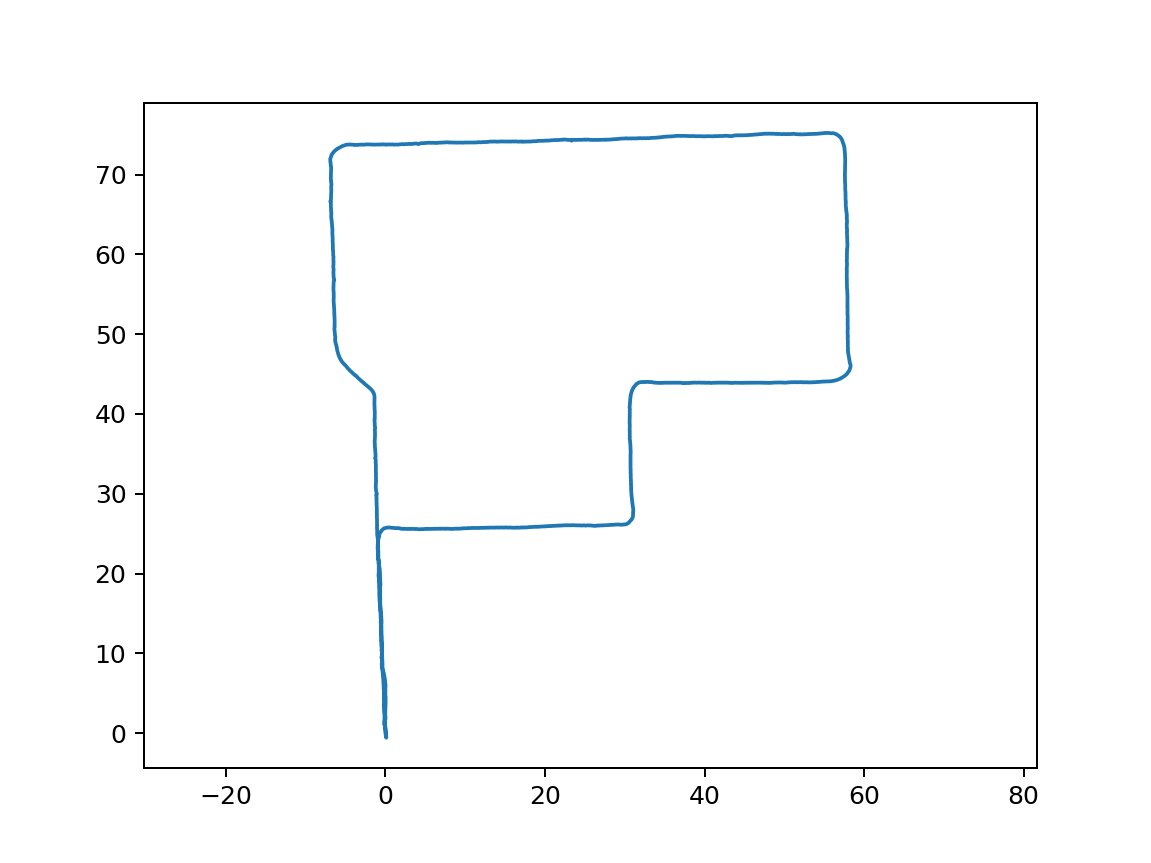

(-10.184242434773722,
 61.56379820710717,
 -4.3695713393604585,
 79.02243831664961)

In [71]:
node_poses = np.array(node_poses)
st = 0; stp = -1
plt.figure()
plt.plot(node_poses[st:stp,0], node_poses[st:stp,1], )
# plt.plot(oposes[st:stp,0], oposes[st:stp,1], )
plt.axis('equal')